In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from ofm_OT_likelihood import *
from models.fno import FNO

from util.true_gaussian_process import *


import statsmodels.api as sm

# for GP regression validation 
import statsmodels.api as sm
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import os

In [2]:

train_samples = 20000

n_x = 128
dims = [n_x]


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

spath = Path('your_path/TGP')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters
torch.manual_seed(22) # fix the seed for reproducible regression result
modes = 32
width = 256
mlp_width = 128

# GP hyperparameters
kernel_length = 0.01
kernel_variance=1
nu = 0.5 # default


## Dataset parameters
length_scale_x = 0.3
var_x = 1
nu_x = 1.5

## training parameters
epochs = 500
sigma_min=1e-4
N = 1
batch_size = 1024

In [3]:
def reject_resample(dims, gpr_model, lb_value, ub_value, num=5000):
    # based on the resample strategy 
    samples = 0
    y_tr_samples = []
    
    while samples < num:
        y_samples = gpr_model.sample_train_data(dims, num)

        print('y_sample.shape:{}'.format(y_samples.shape))
        logic_value = (y_samples <= ub_value) & (y_samples >=lb_value)
        pass_id = torch.all(logic_value, dim=-1).squeeze()

        n_generated = len(y_samples[pass_id])
        if n_generated > 0:
            samples += n_generated 
            y_tr_samples.append(y_samples[pass_id])
            #print("finished {}/{}".format(samples, num))
    y_tr_samples = torch.vstack(y_tr_samples)
    y_tr_samples = y_tr_samples[:num]
    return y_tr_samples

y_sample.shape:torch.Size([20000, 1, 128])
y_sample.shape:torch.Size([20000, 1, 128])
y_sample.shape:torch.Size([20000, 1, 128])
y_sample.shape:torch.Size([20000, 1, 128])
y_sample.shape:torch.Size([20000, 1, 128])
torch.Size([20000, 1, 128])


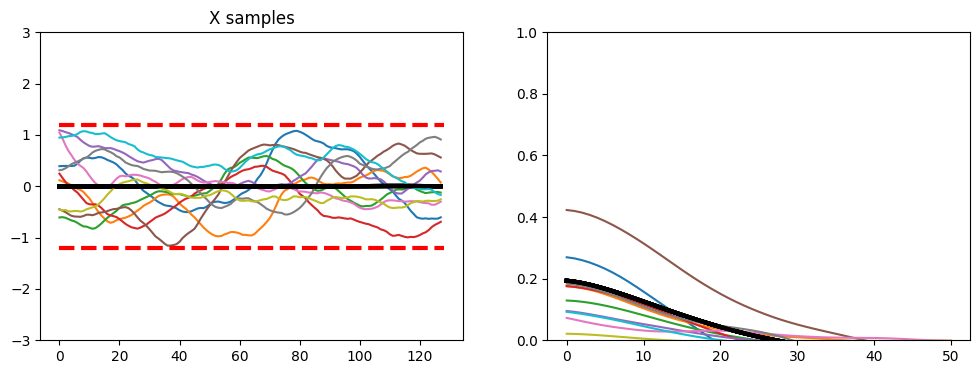

In [4]:
## Prepare training dataset
bound_value = 1.2
ub_value = bound_value
lb_value= -bound_value

GP_1C = true_GPPrior(lengthscale=length_scale_x, var=var_x, nu=nu_x, device='cpu', dims=dims)
x_test = reject_resample(dims, GP_1C, lb_value, ub_value, train_samples)

#x_test = GP_1C.sample_from_prior(dims=dims, n_samples=train_samples)

loader_tr = DataLoader(x_test, batch_size=batch_size, shuffle=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
x_mean_true = x_test.mean(dim=0).squeeze()
x_hist_true, bin_edges = x_test.histogram(range=[-4,4], density=True)

# calculate the autocovaraince
x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_test[i,0,:].numpy(), nlag=50)) for i in range(train_samples)]).mean(dim=0)
#train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test), batch_size=batch_size, shuffle=True)

print(x_test.shape)
for i in range(10):
    x = x_test[i,0]
    ax[0].plot(x)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(x_mean_true, c='k', lw=3)
    ax[0].set_title("X samples")
    ax[1].plot(x_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(x, nlag=50))
    ax[1].set_ylim([0.0, 1.0])
ax[0].plot([0, n_x], [bound_value, bound_value],c='r', ls='--', lw=3)
ax[0].plot([0, n_x], [-bound_value, -bound_value],c='r', ls='--', lw=3)
plt.show()

## load trained model

In [5]:
## load trained model

model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=1, t_scaling=1).to(device)
    
for param in model.parameters():
    param.requires_grad = False
    
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_500.pt')
checkpoint = torch.load(model_path, map_location='cpu',weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [6]:
x_hist_true, bin_edges = x_test.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

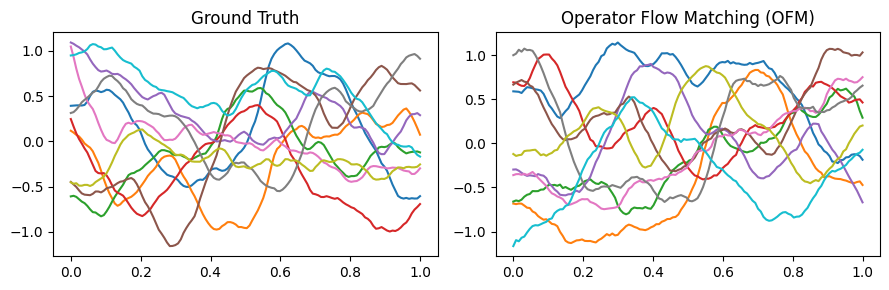

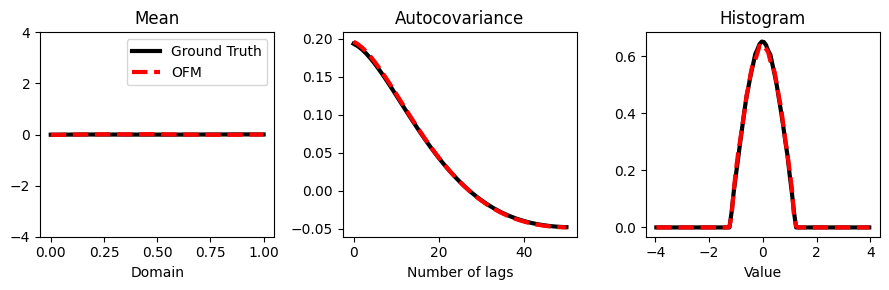

In [7]:
with torch.no_grad():
    X_hat = fmot.sample([n_x], n_samples=10, n_eval=10).cpu().squeeze()
    X_ground_truth = x_test[:10].squeeze()
    # plot
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    
    X_alt = []
    for i in range(3):
        X_temp = fmot.sample([n_x], n_samples=1000, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)    
    for i in range(10):
        x = X_hat[i,:]
        x_ground_truth = X_ground_truth[i,:]
        ax[0].plot(x_pos, x_ground_truth)
        ax[0].set_title('Ground Truth')
        ax[1].plot(x_pos, x)
        ax[1].set_title('Operator Flow Matching (OFM)')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}_samples.pdf")
    
    x_mean = X_alt.mean(dim=0)
    x_acovf = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i, :], nlag=50)) for i in range(3000)]).mean(dim=0)
    
    fig, ax = plt.subplots(1,3, figsize=(9,3))
    ax[0].plot(x_pos, x_mean_true, c='k', lw=3, label='Ground Truth')
    ax[0].plot(x_pos, x_mean, c='r', ls='--', lw=3, label='OFM')
    ax[0].set_xlabel('Domain')
    ax[0].set_ylim([-4,4])
    ax[0].set_title('Mean')
    ax[1].plot(x_acovf_true, c='k', lw=3)
    ax[1].plot(x_acovf, c='r',ls='--', lw=3)
    #ax[1].set_ylim([0,0.5])
    ax[1].set_xlabel('Number of lags')
    ax[1].set_title('Autocovariance')
    ax[2].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3, label='Ground Truth')
    ax[2].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3, label='OpFlow')
    ax[2].set_title('Histogram')
    ax[2].set_xlabel('Value')
    ax[0].legend(loc='upper right')
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}_statistic.pdf")

## Regression 

2D Regression
$$\log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \Big| \lbrace \widehat u(x_i) \rbrace_{i=1}^n \right) =  -\frac{\sum_{i=1}^n \lVert \widehat u(x_i) - u(x_i) \rVert^2}{2\sigma^2} + \log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \right) + C  
$$

In [8]:
x_test.shape

torch.Size([20000, 1, 128])

In [16]:
# lr : learning rate used in MAP estimation
# noise_level: a predefined noise-level, \sigma^2

ndim = n_x #128
lr = 1e-3 
epochs = 2000
noise_level = 0.001

# extract 3 random observations from a test sample
pos_mask = torch.zeros(ndim)
pos_idx = np.array([79,17, 50])


pos_mask[pos_idx] = 1


pos_mask = (pos_mask==1)

# The ground truth that we used to extract random observation
#np.unique(np.where(x_test >=1.15)[0]), to find an example around the bound
#u_obs_full = x_test[816:817,0:1]
u_obs_full = x_test[660:661,0:1]
u_obs_part = u_obs_full[:,:,pos_mask].to(device)

noise_pattern =  torch.randn_like(u_obs_part)

u_obs_part = u_obs_part + noise_pattern* np.sqrt(noise_level)

# saved for further use
u_obs_full = u_obs_full.squeeze()
u_obs_part_detach = u_obs_part.detach().cpu()

In [ ]:
x_range = np.linspace(0,1,ndim)
X = x_range.reshape(-1, 1)

plt.plot(x_range, u_obs_full, label='Ground Truth full', lw=3, c='#1f77b4')
plt.scatter(x_range[pos_mask], u_obs_part_detach , s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.title('1D Resolution 128', fontsize=12)
plt.legend()

## Ground Truth GP
# u shouldn't add the white kernel ( do that only in estimation noisy level, build a second GP whith alpha)
#true_kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)  + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed')
true_kernel = 1.0 * Matern(length_scale=length_scale_x, nu=nu_x) 

gpr_model_ground_truth = GaussianProcessRegressor(kernel=true_kernel, alpha=noise_level)

x_obs = x_range[pos_mask][:,np.newaxis]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model 

y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_samples = gpr_model_ground_truth.sample_y(X, 5)

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(8, 8))
for idx, single_prior in enumerate(y_samples.T):
    ax.plot(
        x_range,
        single_prior,
        linestyle="--",
        alpha=0.7,
        c = 'y'
    )
    if idx==4:
        ax.plot(
            x_range,
            single_prior,
            linestyle="--",
            alpha=0.7,
            c = 'y',
            label=f"Sampled function from true GP",
        )        
    

ax.plot(x_range, y_mean, color="black", label="Mean from true GP")
ax.fill_between(
    x_range,
    y_mean - y_std,
    y_mean + y_std,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot([0, 1], [bound_value, bound_value],c='r', ls='--', lw=3)
ax.plot([0, 1], [-bound_value, -bound_value],c='r', ls='--', lw=3)
plt.scatter(x_range[pos_mask], u_obs_part_detach , s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.plot(x_range, u_obs_full, label='Ground Truth full', lw=2, c='r')
ax.legend()

# GP posterior fit

In [23]:
ub_value = bound_value
lb_value= -bound_value

# just used for sample,length_scale_bounds='fixed' or not doesn't matter
prior_kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed',nu=nu_x) 

gpr_model_prior = GaussianProcessRegressor(kernel=prior_kernel)

def sample_from_posterior(pos_idx, u_obs_full, value_range=0.10, gpr_model=gpr_model_prior, num=20000, n_target=1000):
    """
    pos_idx : list of int, like [10, 80]
    u_obs_full : torch.size([ndim])
    """
    samples = 0
    y_tr_samples = []
    u_obs_full = u_obs_full.numpy()
    
    while samples < n_target:
        # generate `num` samples once
        y_samples = gpr_model.sample_y(X, num, random_state=None)[:,:,np.newaxis]

        # y_sample : [ndim, num]
        logic_value = (y_samples <= ub_value) & (y_samples >=lb_value)
        pass_id = np.all(logic_value, axis=0).squeeze()
        pass_logic = np.zeros(num)
        pass_logic[pass_id] = 1
        pass_logic = (pass_logic==1)

        ## observation id 
        obs_logic_value = np.ones(num)
        obs_logic_value = (obs_logic_value==1)

        for cur_pos in pos_idx:

            cur_logic_value = (y_samples[cur_pos] <= (u_obs_full[cur_pos] + value_range)) & (y_samples[cur_pos] >= (u_obs_full[cur_pos] - value_range))
            obs_logic_value = cur_logic_value.squeeze() & obs_logic_value

        # final idx 
        final_id = pass_logic & obs_logic_value
        n_generated = y_samples[:,final_id].shape[1]
        if n_generated > 0:
            samples += n_generated 
            y_tr_samples.append(y_samples[:,final_id])
            print("finished {}/{}".format(samples, n_target))
    y_tr_samples = np.hstack(y_tr_samples)
    y_tr_samples = y_tr_samples[:,:n_target]
    return y_tr_samples

In [24]:
true_posterior_samples = sample_from_posterior(pos_idx, u_obs_full, value_range=0.10, gpr_model=gpr_model_prior, num=20000, n_target=1000)

finished 1/1000
finished 3/1000
finished 4/1000
finished 5/1000
finished 6/1000
finished 7/1000
finished 8/1000
finished 10/1000
finished 12/1000
finished 14/1000
finished 15/1000
finished 17/1000
finished 19/1000
finished 20/1000
finished 21/1000
finished 22/1000
finished 24/1000
finished 25/1000
finished 26/1000
finished 27/1000
finished 28/1000
finished 30/1000
finished 33/1000
finished 34/1000
finished 37/1000
finished 38/1000
finished 39/1000
finished 41/1000
finished 43/1000
finished 45/1000
finished 46/1000
finished 47/1000
finished 48/1000
finished 49/1000
finished 51/1000
finished 53/1000
finished 55/1000
finished 57/1000
finished 58/1000
finished 60/1000
finished 61/1000
finished 62/1000
finished 65/1000
finished 66/1000
finished 67/1000
finished 68/1000
finished 69/1000
finished 71/1000
finished 72/1000
finished 73/1000
finished 74/1000
finished 75/1000
finished 77/1000
finished 78/1000
finished 79/1000
finished 80/1000
finished 81/1000
finished 82/1000
finished 83/1000
fini

finished 718/1000
finished 721/1000
finished 722/1000
finished 723/1000
finished 724/1000
finished 725/1000
finished 726/1000
finished 727/1000
finished 729/1000
finished 730/1000
finished 732/1000
finished 734/1000
finished 735/1000
finished 736/1000
finished 738/1000
finished 739/1000
finished 740/1000
finished 744/1000
finished 746/1000
finished 747/1000
finished 748/1000
finished 749/1000
finished 750/1000
finished 753/1000
finished 754/1000
finished 756/1000
finished 758/1000
finished 760/1000
finished 761/1000
finished 763/1000
finished 765/1000
finished 768/1000
finished 769/1000
finished 770/1000
finished 771/1000
finished 772/1000
finished 777/1000
finished 780/1000
finished 781/1000
finished 782/1000
finished 783/1000
finished 784/1000
finished 785/1000
finished 787/1000
finished 790/1000
finished 792/1000
finished 793/1000
finished 794/1000
finished 797/1000
finished 799/1000
finished 801/1000
finished 802/1000
finished 804/1000
finished 805/1000
finished 806/1000
finished 8

In [25]:
## save the posterior samples

In [26]:
saved_folder = 'GP2TGP_OFM'
if not os.path.exists(f"../Regression_results/{saved_folder}"):
    os.makedirs(f"../Regression_results/{saved_folder}")

In [27]:
np.save(f"../Regression_results/{saved_folder}/TGP_samples.npy", true_posterior_samples)

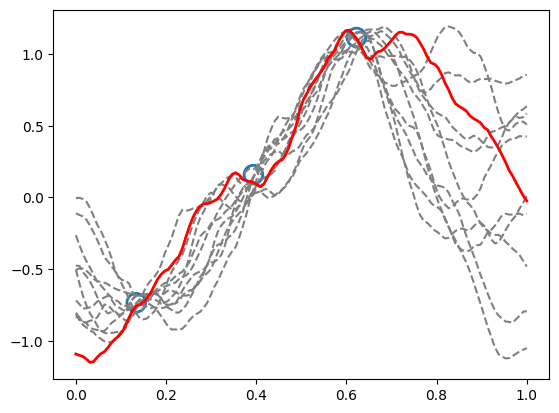

In [28]:
for i in range(10):
    plt.plot(x_range, true_posterior_samples[:,i].squeeze(), c='grey', ls='--')
plt.scatter(x_range[pos_mask], u_obs_part_detach, s=180,  lw=2,facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.plot(x_range, u_obs_full, label='Ground Truth full', lw=2, c='r')

## Regression on Gaussian Process space

In [29]:
G = fmot

In [30]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,1, ndim))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inv_sample(self.a_target, n_eval=4, forward=True)
        
    def logp(self):
        u, out_logp, prior_logp = self.G.data_likelihood_precise(self.a_target, n_eval=4, forward=True)

        return u, out_logp

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        cur_u, cur_logp = reg_opflow_a.logp()
        
        #loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_a.target_u()[:, :, pos_mask])**2)/noise_level
        #loss2 = reg_opflow_a.logp()
        loss1 = -0.5*torch.sum((u_obs_part[0] - cur_u[:,  pos_mask])**2)/noise_level
        loss2 = cur_logp
        
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses

In [31]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [32]:
lr = 1e-3 
#lr = 5e-2

In [33]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

epcoh:0, loss:1487.319091796875
epcoh:1, loss:1483.1199951171875
epcoh:2, loss:1483.681396484375
epcoh:3, loss:1481.520263671875
epcoh:4, loss:1474.097900390625
epcoh:5, loss:1460.259765625
epcoh:6, loss:1461.500244140625
epcoh:7, loss:1455.9407958984375
epcoh:8, loss:1455.4339599609375
epcoh:9, loss:1448.2950439453125
epcoh:10, loss:1439.6148681640625
epcoh:11, loss:1434.15966796875
epcoh:12, loss:1431.2913818359375
epcoh:13, loss:1425.92333984375
epcoh:14, loss:1420.539306640625
epcoh:15, loss:1423.21728515625
epcoh:16, loss:1413.802001953125
epcoh:17, loss:1408.556396484375
epcoh:18, loss:1398.563720703125
epcoh:19, loss:1394.5625
epcoh:20, loss:1389.3514404296875
epcoh:21, loss:1384.608642578125
epcoh:22, loss:1384.611572265625
epcoh:23, loss:1374.719970703125
epcoh:24, loss:1364.6134033203125
epcoh:25, loss:1376.0029296875
epcoh:26, loss:1362.31640625
epcoh:27, loss:1355.688232421875
epcoh:28, loss:1361.326171875
epcoh:29, loss:1353.2222900390625
epcoh:30, loss:1344.482421875
epco

epcoh:249, loss:800.5868530273438
epcoh:250, loss:804.971435546875
epcoh:251, loss:805.2053833007812
epcoh:252, loss:801.26171875
epcoh:253, loss:797.3244018554688
epcoh:254, loss:805.5720825195312
epcoh:255, loss:799.099609375
epcoh:256, loss:795.8145141601562
epcoh:257, loss:794.4580688476562
epcoh:258, loss:793.196044921875
epcoh:259, loss:787.7864990234375
epcoh:260, loss:798.0010986328125
epcoh:261, loss:795.2739868164062
epcoh:262, loss:788.68408203125
epcoh:263, loss:793.5245971679688
epcoh:264, loss:797.4368896484375
epcoh:265, loss:788.6093139648438
epcoh:266, loss:792.8697509765625
epcoh:267, loss:791.079833984375
epcoh:268, loss:795.5819091796875
epcoh:269, loss:784.7166748046875
epcoh:270, loss:783.1970825195312
epcoh:271, loss:789.0712890625
epcoh:272, loss:785.1617431640625
epcoh:273, loss:781.1149291992188
epcoh:274, loss:778.98291015625
epcoh:275, loss:776.4472045898438
epcoh:276, loss:776.4577026367188
epcoh:277, loss:780.5458984375
epcoh:278, loss:775.2999267578125
ep

epcoh:495, loss:666.8173217773438
epcoh:496, loss:675.26513671875
epcoh:497, loss:662.4050903320312
epcoh:498, loss:670.5907592773438
epcoh:499, loss:668.9782104492188
epcoh:500, loss:665.13916015625
epcoh:501, loss:671.0794677734375
epcoh:502, loss:664.9214477539062
epcoh:503, loss:669.8804321289062
epcoh:504, loss:666.5599365234375
epcoh:505, loss:665.05908203125
epcoh:506, loss:666.32177734375
epcoh:507, loss:664.825927734375
epcoh:508, loss:668.6671752929688
epcoh:509, loss:658.9298706054688
epcoh:510, loss:668.6882934570312
epcoh:511, loss:666.3238525390625
epcoh:512, loss:671.333740234375
epcoh:513, loss:670.0651245117188
epcoh:514, loss:670.9619140625
epcoh:515, loss:667.227783203125
epcoh:516, loss:666.4532470703125
epcoh:517, loss:676.0907592773438
epcoh:518, loss:651.35888671875
epcoh:519, loss:659.14404296875
epcoh:520, loss:663.7998046875
epcoh:521, loss:661.671875
epcoh:522, loss:663.6066284179688
epcoh:523, loss:659.9462280273438
epcoh:524, loss:668.2323608398438
epcoh:52

epcoh:742, loss:637.1402587890625
epcoh:743, loss:636.4139404296875
epcoh:744, loss:638.2927856445312
epcoh:745, loss:640.0455322265625
epcoh:746, loss:635.480712890625
epcoh:747, loss:632.9393310546875
epcoh:748, loss:633.5978393554688
epcoh:749, loss:641.289306640625
epcoh:750, loss:624.913330078125
epcoh:751, loss:643.2147827148438
epcoh:752, loss:634.27490234375
epcoh:753, loss:635.5504150390625
epcoh:754, loss:636.3246459960938
epcoh:755, loss:633.7974853515625
epcoh:756, loss:631.8741455078125
epcoh:757, loss:628.4349975585938
epcoh:758, loss:634.0269165039062
epcoh:759, loss:634.90576171875
epcoh:760, loss:632.6319580078125
epcoh:761, loss:631.05517578125
epcoh:762, loss:640.0662841796875
epcoh:763, loss:627.8754272460938
epcoh:764, loss:633.544189453125
epcoh:765, loss:633.1098022460938
epcoh:766, loss:630.2132568359375
epcoh:767, loss:636.7206420898438
epcoh:768, loss:630.9650268554688
epcoh:769, loss:632.8361206054688
epcoh:770, loss:632.5755004882812
epcoh:771, loss:629.8310

epcoh:987, loss:615.6958618164062
epcoh:988, loss:618.9659423828125
epcoh:989, loss:619.4959106445312
epcoh:990, loss:617.6517333984375
epcoh:991, loss:620.6876831054688
epcoh:992, loss:621.7445068359375
epcoh:993, loss:616.1077270507812
epcoh:994, loss:613.7190551757812
epcoh:995, loss:620.3724365234375
epcoh:996, loss:612.1046752929688
epcoh:997, loss:613.5469970703125
epcoh:998, loss:619.8297119140625
epcoh:999, loss:617.2574462890625
epcoh:1000, loss:620.1701049804688
epcoh:1001, loss:615.9940185546875
epcoh:1002, loss:630.4130859375
epcoh:1003, loss:614.7973022460938
epcoh:1004, loss:614.6812744140625
epcoh:1005, loss:624.1453857421875
epcoh:1006, loss:619.0275268554688
epcoh:1007, loss:624.1385498046875
epcoh:1008, loss:620.1832885742188
epcoh:1009, loss:622.4216918945312
epcoh:1010, loss:622.09228515625
epcoh:1011, loss:621.1536254882812
epcoh:1012, loss:620.46923828125
epcoh:1013, loss:619.8248901367188
epcoh:1014, loss:622.9151000976562
epcoh:1015, loss:621.15966796875
epcoh:1

epcoh:1226, loss:617.69384765625
epcoh:1227, loss:609.9638061523438
epcoh:1228, loss:598.4358520507812
epcoh:1229, loss:609.906494140625
epcoh:1230, loss:615.0110473632812
epcoh:1231, loss:610.2353515625
epcoh:1232, loss:610.245361328125
epcoh:1233, loss:616.59521484375
epcoh:1234, loss:613.7115478515625
epcoh:1235, loss:616.76416015625
epcoh:1236, loss:610.5762939453125
epcoh:1237, loss:609.124755859375
epcoh:1238, loss:613.3236694335938
epcoh:1239, loss:603.3079223632812
epcoh:1240, loss:615.32861328125
epcoh:1241, loss:614.6683349609375
epcoh:1242, loss:615.423095703125
epcoh:1243, loss:610.9263305664062
epcoh:1244, loss:612.2913818359375
epcoh:1245, loss:612.4170532226562
epcoh:1246, loss:616.0062255859375
epcoh:1247, loss:604.80712890625
epcoh:1248, loss:613.1627197265625
epcoh:1249, loss:605.9896240234375
epcoh:1250, loss:612.8934326171875
epcoh:1251, loss:609.7007446289062
epcoh:1252, loss:609.4967041015625
epcoh:1253, loss:610.6380004882812
epcoh:1254, loss:616.1939697265625
ep

epcoh:1465, loss:609.4252319335938
epcoh:1466, loss:611.1162109375
epcoh:1467, loss:609.202880859375
epcoh:1468, loss:608.8516845703125
epcoh:1469, loss:611.3811645507812
epcoh:1470, loss:604.2486572265625
epcoh:1471, loss:601.6793823242188
epcoh:1472, loss:613.75341796875
epcoh:1473, loss:608.285888671875
epcoh:1474, loss:607.9036865234375
epcoh:1475, loss:607.2581787109375
epcoh:1476, loss:608.119140625
epcoh:1477, loss:611.3846435546875
epcoh:1478, loss:604.6983032226562
epcoh:1479, loss:607.8367309570312
epcoh:1480, loss:610.4781494140625
epcoh:1481, loss:605.666015625
epcoh:1482, loss:616.6776733398438
epcoh:1483, loss:611.9175415039062
epcoh:1484, loss:609.3994140625
epcoh:1485, loss:607.53662109375
epcoh:1486, loss:613.19921875
epcoh:1487, loss:607.9889526367188
epcoh:1488, loss:598.7518920898438
epcoh:1489, loss:597.5054321289062
epcoh:1490, loss:613.1417236328125
epcoh:1491, loss:611.0609130859375
epcoh:1492, loss:608.9579467773438
epcoh:1493, loss:614.4519653320312
epcoh:1494

epcoh:1703, loss:605.063720703125
epcoh:1704, loss:607.1920776367188
epcoh:1705, loss:604.716796875
epcoh:1706, loss:607.4638061523438
epcoh:1707, loss:608.417236328125
epcoh:1708, loss:604.4447021484375
epcoh:1709, loss:607.6670532226562
epcoh:1710, loss:605.7211303710938
epcoh:1711, loss:608.2863159179688
epcoh:1712, loss:607.04052734375
epcoh:1713, loss:603.4512939453125
epcoh:1714, loss:603.3059692382812
epcoh:1715, loss:608.1590576171875
epcoh:1716, loss:604.6578979492188
epcoh:1717, loss:611.9280395507812
epcoh:1718, loss:612.1754150390625
epcoh:1719, loss:609.20458984375
epcoh:1720, loss:605.988525390625
epcoh:1721, loss:603.8414916992188
epcoh:1722, loss:604.6879272460938
epcoh:1723, loss:608.07763671875
epcoh:1724, loss:606.6480712890625
epcoh:1725, loss:601.9456176757812
epcoh:1726, loss:603.863525390625
epcoh:1727, loss:607.73974609375
epcoh:1728, loss:613.38525390625
epcoh:1729, loss:604.8919677734375
epcoh:1730, loss:606.5841674804688
epcoh:1731, loss:615.0734252929688
epc

epcoh:1942, loss:609.7007446289062
epcoh:1943, loss:606.3859252929688
epcoh:1944, loss:609.9633178710938
epcoh:1945, loss:607.097900390625
epcoh:1946, loss:613.55419921875
epcoh:1947, loss:605.417724609375
epcoh:1948, loss:605.9130859375
epcoh:1949, loss:610.82470703125
epcoh:1950, loss:611.5452270507812
epcoh:1951, loss:570.2828369140625
epcoh:1952, loss:594.0803833007812
epcoh:1953, loss:603.5819702148438
epcoh:1954, loss:601.6982421875
epcoh:1955, loss:610.9931640625
epcoh:1956, loss:605.9254150390625
epcoh:1957, loss:609.1119995117188
epcoh:1958, loss:602.8727416992188
epcoh:1959, loss:597.6624755859375
epcoh:1960, loss:606.2862548828125
epcoh:1961, loss:605.1661376953125
epcoh:1962, loss:600.361083984375
epcoh:1963, loss:603.511474609375
epcoh:1964, loss:605.6484375
epcoh:1965, loss:602.0443115234375
epcoh:1966, loss:605.942138671875
epcoh:1967, loss:600.8356323242188
epcoh:1968, loss:597.8063354492188
epcoh:1969, loss:605.3717651367188
epcoh:1970, loss:606.9840698242188
epcoh:197

In [34]:
## validation on the MAP result

In [35]:
test = reg_opflow_a.target_u()

In [ ]:
x_range = np.linspace(0,1,ndim)
X = x_range.reshape(-1, 1)

plt.plot(x_range, u_obs_full, label='Ground Truth full', lw=3, c='#1f77b4')
plt.plot(x_range, test.detach().cpu().numpy().squeeze(),label='OFM')
plt.plot(x_range, y_mean, color="black", label="Mean from true GP")
plt.scatter(x_range[pos_mask], u_obs_full[pos_mask], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.title('1D Resolution 128', fontsize=12)
plt.legend()

## SGLD sampling

In [40]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_FSGLD

import sampling_FSGLD.samplers


import sampling_FSGLD.SGLD
reload(sampling_FSGLD.SGLD)

# reload order matter, sampler should be after sgld
reload(sampling_FSGLD.samplers)
from sampling_FSGLD.samplers import LangevinDynamics,MetropolisAdjustedLangevin

import copy
from tqdm import tqdm

/tmp/ipykernel_3203611/3722995193.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [41]:
## Regression on a

In [42]:
a_opflow_copy = reg_opflow_a.a_target.data.cpu().detach().clone()
u_opflow_copy = reg_opflow_a.target_u().cpu().detach().clone()

In [43]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood

    cur_u, cur_logp, _ = G.data_likelihood_precise(a, n_eval=4, forward=True)
    loss1 = -0.5*torch.sum((u_obs_part[0] - cur_u[:,  pos_mask])**2)/noise_level
    loss2 = cur_logp

    loss = -(loss1 + loss2)    
    
    return loss

In [44]:

## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)
#x = nn.Parameter(u_opflow_copy, requires_grad=True).to(device)
#x = torch.zeros([2], requires_grad=True, device=device)

temperature = 1
momentum = 0

max_itr = int(4e4)
## should sample 6e4 to guarantee the smooth. 


# only designed for function SGLD
langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=5e-3,
                                     lr_final=4e-3,
                                     max_itr=max_itr,
                                     pos_mask=pos_mask,
                                     device=device,
                                     temperature = temperature,
                                     momentum = momentum
                                     )

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1
start, white noise on A


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [5:25:55<00:00,  2.05it/s]


In [45]:
a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
#u_samples_all = G.inverse(a_samples_all)

In [46]:
import math
split_batch = 100
num_batches = math.ceil(a_samples_all.size()[0]/split_batch)
X_list = [a_samples_all[split_batch*y:split_batch*(y+1),:,:] for y in range(num_batches)]
print(X_list[0].size())

u_samples_all = []
with torch.no_grad():
    for cur_a_sample in X_list:
        u_samples_all.append(G.inv_sample(cur_a_sample, n_eval=4, forward=True))
        
u_samples_all = torch.vstack(u_samples_all)

torch.Size([100, 1, 128])


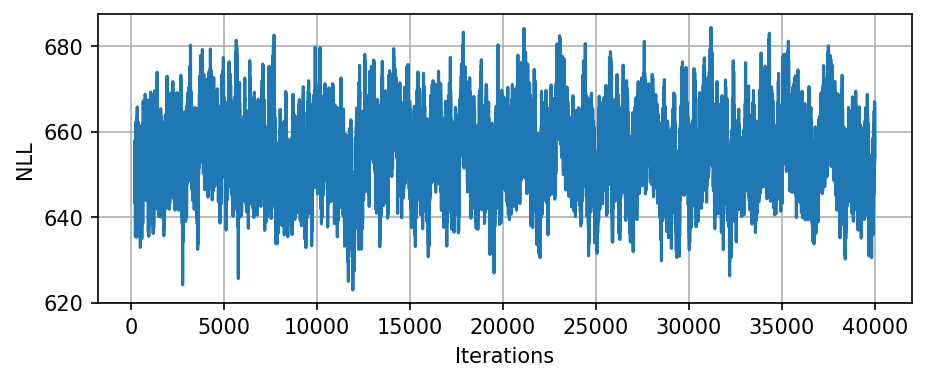

In [50]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(200, len(loss_log)),loss_log[200:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

## Get target U

In [85]:
est_samples = u_samples_all.detach().cpu().numpy()
est_samples = est_samples[300:]

In [86]:
x = np.linspace(0, 1, ndim)
X = x.reshape(-1, 1)

In [87]:
y_mean = true_posterior_samples.squeeze().mean(axis=-1)

In [88]:
y_std = true_posterior_samples.squeeze().std(axis=-1)

Text(0, 0.5, 'value')

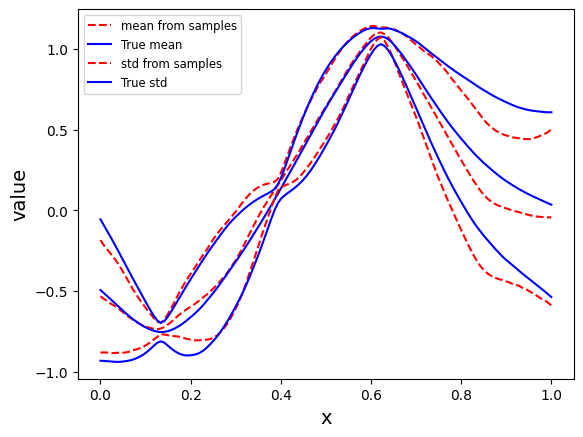

In [6]:
sample_std = np.std(est_samples, axis=0).squeeze()
sample_mean = np.mean(est_samples, axis=0).squeeze()

plt.plot(x, sample_mean, c='r', ls='--', label='mean from samples')
plt.plot(x, y_mean, c='b', label='True mean')
plt.plot(x, sample_mean-sample_std, c='r', ls='--', label='std from samples')
plt.plot(x, sample_mean+sample_std, c='r', ls='--')
plt.plot(x, y_mean-y_std,c='b', label='True std' )
plt.plot(x,y_mean+y_std, c='b')
plt.legend(fontsize='small')
plt.xlabel('x', fontsize=14)
plt.ylabel('value', fontsize=14)
#plt.savefig(f"paper_pdf/{folder}_SGLD_mean_std.pdf")

## Plot

In [9]:
#y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
#y_samples = gpr_model_ground_truth.sample_y(X, len(est_samples)).T


opflow_std = np.std(est_samples, axis=0).squeeze()
opflow_mean = np.mean(est_samples, axis=0).squeeze()

sample_idx = np.random.choice(len(est_samples), 5, replace=False)

samples_opflow = est_samples[sample_idx].squeeze()
samples_ground_truth = true_posterior_samples[:,:5].squeeze().T


In [32]:
saved_folder = 'GP2TGP_OFM'
if not os.path.exists(f"../Regression_results/{saved_folder}"):
    os.makedirs(f"../Regression_results/{saved_folder}")

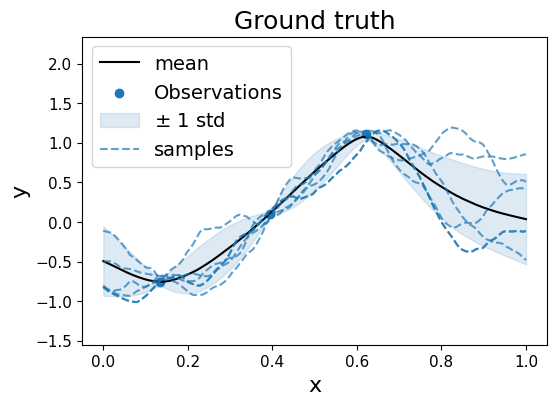

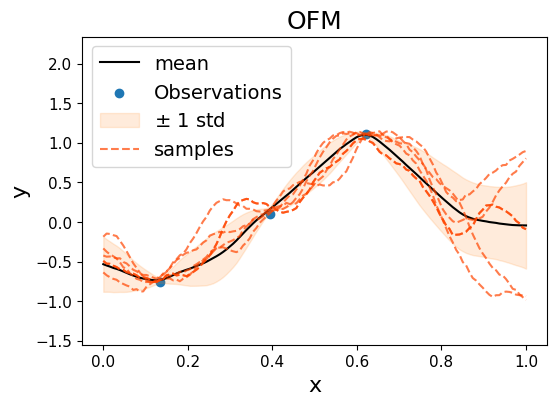

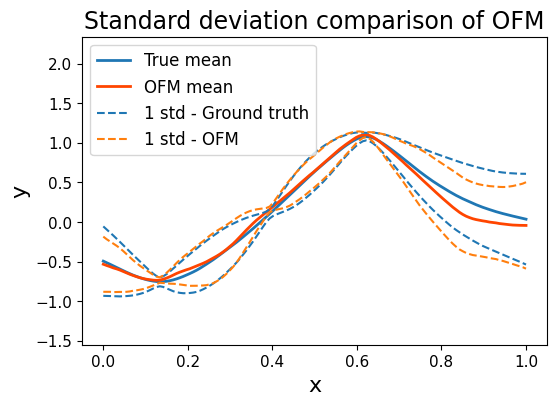

In [45]:
## Figure 1 (Ground Truth : mean + std + samples)
## Figure 2 (OpFlow : mean + std _samples)
## Figure 3 (Mean and Std comparision) 
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(x_range, y_mean, c='k', label='mean')
ax.scatter(x_range[pos_mask], u_obs_full[pos_mask],edgecolors='#1f77b4', label="Observations")
ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.15, color="#1f77b4", label=r"$\pm$ 1 std")
for idx, single_prior in enumerate(samples_ground_truth):
    ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#1f77b4')
    if idx==0:
        ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#1f77b4', label=f"samples")

ax.set_title('Ground truth', fontsize=18)       
ax.legend(loc='upper left', fontsize=14)
#y_lims = ax.get_ylim()
ax.set_ylim(y_lims)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y',fontsize=16)
plt.tick_params( labelsize=11)
#plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/TGP_reg_gt.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(x_range, opflow_mean, c='black', label='mean')
ax.scatter(x_range[pos_mask], u_obs_full[pos_mask],edgecolors='#1f77b4', label="Observations")
ax.fill_between(x, opflow_mean - opflow_std, opflow_mean + opflow_std, alpha=0.15, color="#ff7f0e", label=r"$\pm$ 1 std")
for idx, single_prior in enumerate(samples_opflow):
    ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#FF4500')
    if idx==0:
        ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#FF4500', label=f"samples")
ax.set_title('OFM', fontsize=18)
#ax.set_title('OpFlow - Regression on A, white noise', fontsize=14)
ax.legend(loc='upper left', fontsize=14)
ax.set_ylim(y_lims)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y',fontsize=16)
plt.tick_params( labelsize=11)
#plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/TGP_reg_ofm.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title('Standard deviation comparison of OFM', fontsize=17)
ax.plot(x_range, y_mean, lw=2, c='#1f77b4', label='True mean')
ax.plot(x_range, opflow_mean, lw=2, c='#FF4500', label='OFM mean')
#ax.plot(x_range, u_opflow_copy.squeeze(), lw=2, c='k', label='OpFlow MAP' )
ax.plot(x, y_mean-y_std,ls='--',c='#1f77b4', label=r'1 std - Ground truth' )
ax.plot(x,y_mean+y_std,ls='--', c='#1f77b4')
#ax.plot(x, y_mean-opflow_std, c='#ff7f0e', ls='--', label=r'1 $\sigma$ - OpFlow')
#ax.plot(x, y_mean+opflow_std, c='#ff7f0e', ls='--')
ax.plot(x, opflow_mean-opflow_std, c='#ff7f0e', ls='--', label=r'1 std - OFM')
ax.plot(x, opflow_mean+opflow_std, c='#ff7f0e', ls='--')
ax.legend(loc='upper left', fontsize=12)
ax.set_ylim(y_lims)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y',fontsize=16)
plt.tick_params( labelsize=11)
#plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/TGP_reg_uncertainty.pdf")

In [16]:
## Mean squared error - \mu (misfit)
## Mean squared  error - \sigma 

In [22]:
gp_prior_mean, gp_prior_std = gpr_model_ground_truth.predict(X, return_std=True)
gp_prior_samples = gpr_model_ground_truth.sample_y(X, 20).T
gp_prior_samples = gp_prior_samples[:5]

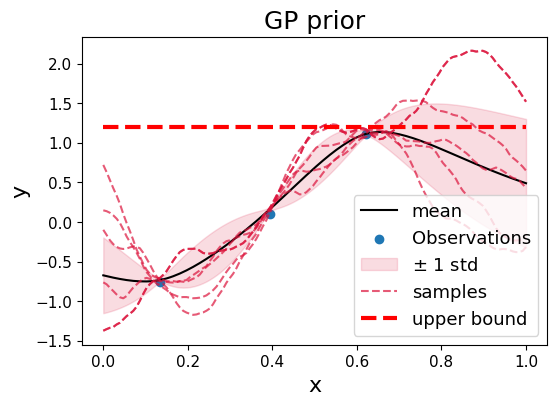

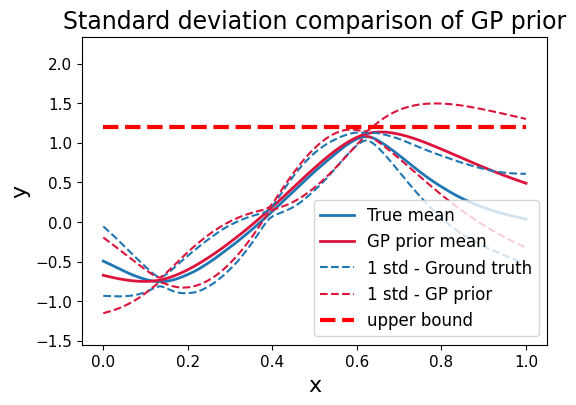

In [44]:
## should show the results of fitting GP prior
# draw a line at 1.2 red,  dash line 
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(x_range, gp_prior_mean, c='black', label='mean')
ax.scatter(x_range[pos_mask], u_obs_full[pos_mask],edgecolors='#1f77b4', label="Observations")
ax.fill_between(x, gp_prior_mean - gp_prior_std, gp_prior_mean + gp_prior_std, alpha=0.15, color="#DC143C", label=r"$\pm$ 1 std")
for idx, single_prior in enumerate(gp_prior_samples):
    ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#DC143C')
    if idx==0:
        ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#DC143C', label=f"samples")
ax.plot([0, 1], [bound_value, bound_value],c='r', ls='--', lw=3, label='upper bound')
ax.set_title('GP prior', fontsize=18)
#ax.set_title('OpFlow - Regression on A, white noise', fontsize=14)
y_lims = ax.get_ylim()
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y',fontsize=16)
plt.tick_params( labelsize=11)
#plt.tight_layout()
ax.legend(loc='lower right', fontsize=13)
plt.savefig(f"../Regression_results/{saved_folder}/TGP_reg_prior.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title('Standard deviation comparison of GP prior', fontsize=17)
ax.plot(x_range, y_mean, lw=2, c='#1f77b4', label='True mean')
ax.plot(x_range, gp_prior_mean, lw=2, c='#DC143C', label='GP prior mean')
#ax.plot(x_range, u_opflow_copy.squeeze(), lw=2, c='k', label='OpFlow MAP' )
ax.plot(x, y_mean-y_std,ls='--',c='#1f77b4', label=r'1 std - Ground truth' )
ax.plot(x,y_mean+y_std,ls='--', c='#1f77b4')
#ax.plot(x, y_mean-opflow_std, c='#ff7f0e', ls='--', label=r'1 $\sigma$ - OpFlow')
#ax.plot(x, y_mean+opflow_std, c='#ff7f0e', ls='--')
ax.plot(x, gp_prior_mean-gp_prior_std, c='#DC143C', ls='--', label=r'1 std - GP prior')
ax.plot(x, gp_prior_mean+gp_prior_std, c='#DC143C', ls='--')
ax.plot([0, 1], [bound_value, bound_value],c='r', ls='--', lw=3, label='upper bound')
ax.set_ylim(y_lims)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y',fontsize=16)
plt.tick_params( labelsize=11)
#plt.tight_layout()
ax.legend(fontsize=12,loc='lower right')
plt.savefig(f"../Regression_results/{saved_folder}/TGP_reg_prior_uncertainty.pdf")

In [92]:
import h5py
f = h5py.File(f"../Regression_results/{saved_folder}/{saved_folder}.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=pos_idx)
f.create_dataset('noise_patter', data=noise_pattern.detach().cpu().numpy().squeeze())
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()